In [2]:
from typing import Callable, List, Tuple, Iterable

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
#Transforms A and b to the right form
def transform(A, b):
    size = A.shape[0]
    D = np.identity(size)
    A_diag_indices = np.diag(A)
    D[np.diag_indices_from(D)] = A_diag_indices
    HD = np.identity(size) - np.matmul(np.linalg.inv(D), A)
    gD = np.matmul(np.linalg.inv(D), b)
    return HD, gD

def inf_norm(arr):
    return np.linalg.norm(arr, ord=np.inf)


def simple_iteration_method(H, g, k):
    n = H.shape[0]
    x = np.zeros((n, 1))
    count = 0
    while count < k:
        x = np.matmul(H, x) + g
        count = count + 1
        
        
    return x



def seidel_method(H, g, k):
    n = H.shape[0]
    prev_x = np.zeros(n)
    x = np.zeros(n)
    count = 0
    while count < k:
        for i in range(n):
            x[i] = np.dot(H[i, 0:i], x[0:i]) + np.dot(H[i, i:n], prev_x[i:n]) + g[i]
        prev_x = x
        count = count + 1
        
    return x.reshape((n, 1))

In [28]:
coeff = Callable[[float, float], float]
Equation = Tuple[coeff, coeff, coeff]
Boundaries = Tuple[float, float, float, float]

class Solve:
    def __init__(self,
                 coefs : Equation,
                 eps : float, 
                 bounds : Boundaries,
                 mu : coeff,
                 x_coords : int,
                 y_coords : int
                 ):
        self.p, self.q, self.f = coefs
        self.lx, self.rx, self.by, self.uy  = bounds
        self.eps = eps
        self.mu = mu
        self.x_coords = x_coords
        self.y_coords = y_coords
        self.x_net, self.y_net = self._get_net()
        self.hx = (self.rx - self.lx) / self.x_coords
        self.hy = (self.uy - self.by) / self.y_coords
        
    def process(self):
        new_x_size, new_y_size = (self.x_coords - 1), (self.y_coords - 1) 
        A = np.arange(new_x_size * new_y_size).reshape((new_x_size, new_y_size))
        n = self.x_coords - 2
        m = self.y_coords - 2
        interior_points = np.arange(m * n).reshape(n, m)
        
        system = np.arange(n * n * m * m).reshape(m * n, m * n)
        b = np.arange(n * m)
        
        for i in range(m * n):
            for j in range(m * n):
                system[i, j] = 0.0
        
        
        def get_index(i, j):
            return i * m + j
            
        def get_ij(index):
            return (int)(index / m), index % m
        
        def p1(xi, yi):
            return self.p(xi + self.hx / 2, yi)
        
        def p2(xi, yi):
            return self.p(xi - self.hx / 2, yi)
        
        def q1(xi, yi):
            return self.q(xi, yi + self.hy / 2)
        
        def q2(xi, yi):
            return self.q(xi, yi - self.hy / 2)
            
            
     #   for i in range(0, n - 2):
     #       for j in range(0, m - 2):
     #           interiot_points[i, j] = A[i + 1, j + 1]
        
            
        counter = 0
        for i in range(0, n):
            for j in range(0,  m):
                xi = self.x_net[i + 1]
                yi = self.y_net[j + 1]
                
                imj_const = self.mu(xi - self.hx, yi) * p2(xi, yi) / (self.hx ** 2)
                ijm_const = self.mu(xi, yi - self.hy) * q2(xi, yi) / (self.hy ** 2)
                ipj_const = self.mu(xi + self.hx, yi) * p1(xi, yi) / (self.hx ** 2)
                ijp_const = self.mu(xi, yi + self.hy) * q1(xi, yi) / (self.hy ** 2)
                ij_coeff = -p1(xi, yi) / (self.hx ** 2) - p2(xi, yi) / (self.hx ** 2) - q1(xi, yi) / (self.hy ** 2) - q2(xi, yi) / (self.hy ** 2)
                ipj_coeff = p1(xi, yi) / (self.hx ** 2)
                imj_coeff = p2(xi, yi) / (self.hx ** 2)
                ijp_coeff = q1(xi, yi) / (self.hy ** 2)
                ijm_coeff = q2(xi, yi) / (self.hy ** 2)
                
                # Indexes of variable in system of equations.
                index = get_index(i, j)
                index_ipj = get_index(i + 1, j)
                index_ijp = get_index(i, j + 1)
                index_imj = get_index(i - 1, j)
                index_ijm = get_index(i, j - 1)
                
                if i == 0 and j == 0:
                    system[counter, index] = ij_coeff
                    system[counter, index_ipj] = ipj_coeff
                    system[counter, index_ijp] = ijp_coeff
                    right_coeff = - self.f(xi, yi) - imj_const - ijm_const
                    b[counter] = right_coeff
                elif i == n - 1 and j == m - 1:
                    system[counter, index] = ij_coeff
                    system[counter, index_imj] = imj_coeff
                    system[counter, index_ijm] = ijm_coeff
                    right_coeff = - self.f(xi, yi) - ipj_const - ijp_const
                    b[counter] = right_coeff
                elif i == 0 and j == m - 1:
                    system[counter, index] = ij_coeff
                    system[counter, index_ipj] = ipj_coeff
                    system[counter, index_ijm] = ijm_coeff
                    right_coeff = - self.f(xi, yi) - imj_const - ijp_const
                    b[counter] = right_coeff
                elif i == n - 1 and j == 0:
                    system[counter, index] = ij_coeff
                    system[counter, index_ijp] = ijp_coeff
                    system[counter, index_imj] = imj_coeff
                    right_coeff = - self.f(xi, yi) - ijm_const - ipj_const
                    b[counter] = right_coeff
                elif i == 0 and j > 0 and j < m - 1:
                    system[counter, index] = ij_coeff
                    system[counter, index_ipj] = ipj_coeff
                    system[counter, index_ijm] = ijm_coeff
                    system[counter, index_ijp] = ijp_coeff
                    right_coeff = - self.f(xi, yi) - imj_const
                    b[counter] = right_coeff
                elif i == n - 1 and j > 0 and j < m - 1:
                    system[counter, index] = ij_coeff
                    system[counter, index_imj] = imj_coeff
                    system[counter, index_ijm] = ijm_coeff
                    system[counter, index_ijp] = ijp_coeff
                    right_coeff = - self.f(xi, yi) - ipj_const
                    b[counter] = right_coeff
                elif i > 0 and i < n - 1 and j == 0:
                    system[counter, index] = ij_coeff
                    system[counter, index_imj] = imj_coeff
                    system[counter, index_ipj] = ipj_coeff
                    system[counter, index_ijp] = ijp_coeff
                    right_coeff = - self.f(xi, yi) - ijm_const
                    b[counter] = right_coeff
                elif i > 0 and i < n - 1 and j == m - 1:
                    system[counter, index] = ij_coeff
                    system[counter, index_imj] = imj_coeff
                    system[counter, index_ipj] = ipj_coeff
                    system[counter, index_ijm] = ijm_coeff
                    right_coeff = - self.f(xi, yi) - ijp_const
                    b[counter] = right_coeff 
                else:
                    system[counter, get_index(i, j)] = ij_coeff
                    system[counter, get_index(i + 1, j)] = ipj_coeff
                    system[counter, get_index(i - 1, j)] = imj_coeff
                    system[counter, get_index(i, j + 1)] = ijp_coeff
                    system[counter, get_index(i, j - 1)] = ijm_coeff
                    b[counter] = - self.f(xi, yi)
    
    
                counter  = counter + 1
                #ij_coeff = -p1(xi, yi) / (self.hx ** 2) - p2(xi, yi) / (self.hx ** 2) - q1(xi, yi) / (self.hy ** 2) - q2(xi, yi) / (self.hy ** 2)
                # ipj_coeff = p1(xi, yi) / (self.hx ** 2)
                # imj_coeff = p2(xi, yi) / (self.hx ** 2)
                # ijp_coeff = q1(xi, yi) / (self.hy ** 2)
                # ijm_coeff = q2(xi, yi) / (self.hy ** 2)
                # A[counter, get_index(i, j)] = ij_coeff
                # A[counter, get_index(i + 1, j)] = ipj_coeff
                # A[counter, get_index(i - 1, j)] = imj_coeff
                # A[counter, get_index(i, j + 1)] = ijp_coeff
                # x = 1
        
        HD, GD = transform(system, b)
        appr = seidel_method(HD, GD, 8)
        appr1 = np.linalg.solve(system, b)
        result = np.arange(m * n).reshape(n, m)
        for index in range(appr.shape[0]):
            i, j = get_ij(index)
            result[i, j] = appr[index]
            
        return appr #system.shape[0], system.shape[0]
    
    def _get_net(self):
        x_net = np.linspace(self.lx, self.rx, num=self.x_coords)
        y_net = np.linspace(self.by, self.uy, num=self.y_coords)
        return x_net, y_net
    

def p(x, y):
    return 1

def q(x, y):
    return 1

def f(x, y):
    return -6 * x * y - 2 * x

def mu(x, y):
    return (x ** 3) * y + x * (y ** 2)  


#solver = Solve([p, q, f], 1.0, [0.0, 1.0, 0.0, 1.0], mu, 11, 11)
#F, S = solver.process()


#F[10, :]

#HD, GD = transform(F, S)


#x = simple_iteration_method(HD, GD, 5)
#x
#np.ones(5)
mu(1, 1)

2

In [31]:
# Test
solver = Solve([p, q, f], 1.0, [0.0, 1.0, 0.0, 1.0], mu, 81, 81)
solver.process()

#result = np.arange(9 * 9).reshape(9, 9)
#def get_ij(index):
#    return (int)(index / 9), index % 9
        
#for index in range(appr.shape[0]):
#    i, j = get_ij(index)
#    print("data", appr[index])
#    result[i, j] = appr[index]
        
#result

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [1.53100075],
       [1.66151477],
       [1.80563494]])

In [13]:
np.flip(np.linspace(0.0, 1.0, 11))

array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ])

In [10]:
def get_index(i, j, m, n):
        return i * (m - 1) + j
        
        
m = 4
n = 5
a = np.arange(m * n).reshape((n, m))

b = np.arange((m - 2) * (n - 2)).reshape(n - 2, m - 2)

for i in range(0, n - 2):
    for j in range(0, m - 2):
        b[i, j] = a[i + 1, j + 1]
        
a, b

(array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19]]),
 array([[ 5,  6],
        [ 9, 10],
        [13, 14]]))

In [11]:
for i in range(1, 5):
    print(i)

1
2
3
4


In [12]:
def coords(x_net, y_net, m, n):
    for j in range(n):
        for i in range(m):
            print(x_net[i], y_net[j])
            index = get_index(i, j, n, m)
            x = 1
    return 0

m, n = 11, 3
x_net = np.linspace(0.0, 1.0, m)
y_net = np.linspace(2.0, 0.0, n)
y_net
coords(x_net, y_net, m, n)

0.0 2.0
0.1 2.0
0.2 2.0
0.30000000000000004 2.0
0.4 2.0
0.5 2.0
0.6000000000000001 2.0
0.7000000000000001 2.0
0.8 2.0
0.9 2.0
1.0 2.0
0.0 1.0
0.1 1.0
0.2 1.0
0.30000000000000004 1.0
0.4 1.0
0.5 1.0
0.6000000000000001 1.0
0.7000000000000001 1.0
0.8 1.0
0.9 1.0
1.0 1.0
0.0 0.0
0.1 0.0
0.2 0.0
0.30000000000000004 0.0
0.4 0.0
0.5 0.0
0.6000000000000001 0.0
0.7000000000000001 0.0
0.8 0.0
0.9 0.0
1.0 0.0


0

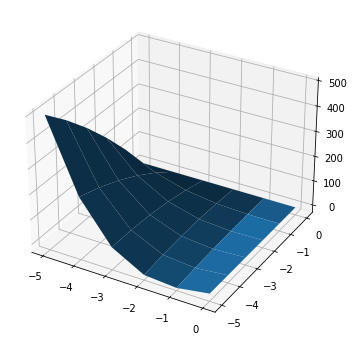

In [75]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
#if using a Jupyter notebook, include:
%matplotlib inline

x = np.arange(-5.0,0.1)
y = np.arange(-5.0, 0.1)
X,Y = np.meshgrid(x,y)
#Z = X*np.exp(-X - Y)
Z = mu(X, Y)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')


# Plot a 3D surface
ax.plot_surface(X, Y, Z)


plt.show()

In [14]:
np.arange(4 * 5).reshape((4, 5))
        

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])

In [15]:
1 == 1

True

In [16]:
d = np.arange(5)
for i in range(1, 4):
    print(i)
    
np.arange(5)

1
2
3


array([0, 1, 2, 3, 4])

In [17]:
n = 4
m = 5

def get_id(i, j):
    return i * m + j
    

def get_ij(index):
    return (int)(index / m), index % m
a = np.arange(m * n).reshape((n, m))
a, get_id(1, 4), get_ij(9)

(array([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]]),
 9,
 (1, 4))

In [18]:
np.arange(5)

array([0, 1, 2, 3, 4])